# Multi Modal Search Using Milvus Vector Database

First Download this Docker Compose file:

``wget https://github.com/milvus-io/milvus/releases/download/v2.3.3/milvus-standalone-docker-compose.yml -O docker-compose.yml
``


Then, run the ``docker compose up`` command to set up the Milvus Server

## Import and Test the Dependencies

In [55]:
import torch
import os 
import glob
import clip
from PIL import Image
from IPython.display import Image as ImageDisplay
import pandas as pd 

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
from pymilvus import connections
from pymilvus import Collection, CollectionSchema, FieldSchema, DataType, utility

### Connect to Milvus

In [4]:
connections.connect(
  alias="default", 
  host='localhost', 
  port='19530'
)

In [5]:
connections.list_connections()

[('default', <pymilvus.client.grpc_handler.GrpcHandler at 0x1ea379ade20>)]

#### Create The Collection

In [6]:
animal_id = FieldSchema(
    name = "animal_id",
    dtype = DataType.INT64,
    is_primary = True,
)
file_path = FieldSchema(
    name = "file_path",
    dtype = DataType.VARCHAR,
    max_length = 300,
    default_value = "UNKNOWN",
)
file_type = FieldSchema(
    name = "file_type",
    dtype = DataType.VARCHAR,
    max_length = 50,
    default_value = "UNKNOWN",
)
text_data = FieldSchema(
    name = "text_data",
    dtype = DataType.VARCHAR,
    max_length = 500,
    default_value = "null",
)
animal_vector = FieldSchema(
  name = "animal_vector",
  dtype = DataType.FLOAT_VECTOR,
  dim = 512
)

In [7]:
schema = CollectionSchema(
  fields=[animal_id, file_type, file_path, text_data, animal_vector],
  description="Animal Search, Images, Facts",
  enable_dynamic_field=True,
  auto_id=False,
)

In [8]:
_COLLECTION_NAME = "animals"
_DATA_DIRECTORY = "./data"

In [9]:
if utility.has_collection(_COLLECTION_NAME):
    utility.drop_collection(_COLLECTION_NAME)

collection = Collection(
    name=_COLLECTION_NAME,
    schema=schema,
    using='default',
    shards_num=2
)

In [21]:
search_params = {
    "metric_type": "L2", 
    "offset": 0, 
    "ignore_growing": False, 
    "params": {"nprobe": 10}
}

In [10]:
index_ = {
    "index_type": "IVF_FLAT",
    "metric_type": "L2",
    "params": {"nlist": 128},
}
collection.create_index("animal_vector", index_)

Status(code=0, message=)

## Check Data

In [11]:
glob.glob(_DATA_DIRECTORY+"/*")

['./data\\audio', './data\\facts', './data\\images']

In [12]:
data_paths = dict()
for classes in glob.glob(glob.glob(_DATA_DIRECTORY+"/*")[0]+"/*"):
    data_paths[classes.split("\\")[-1]] = dict()
    for type_of_data in glob.glob(_DATA_DIRECTORY+"/*"):
        data_paths[classes.split("\\")[-1]][type_of_data.split("\\")[-1]] = list()

In [13]:
for type_of_data in ["audio", "images"]:
    for classes in list(data_paths.keys()):
        data_paths[classes][type_of_data] = glob.glob(_DATA_DIRECTORY+f"/{type_of_data}/{classes}/*")

In [14]:
for classes in list(data_paths.keys()):
    my_file = open(f"./data/facts/{classes}.txt", "r") 
    data = my_file.read() 
    data_paths[classes]["facts"] = data.split("\n")
    my_file.close()

### Get the Model

In [15]:
model, preprocess = clip.load("ViT-B/32", device=device)

In [16]:
index_id = 0
for animal in list(data_paths.keys()):
    for fact in data_paths[animal]["facts"]:
        index_id += 1
        _fact = clip.tokenize(fact).to(device)
        _fact_embedding = model.encode_text(_fact)
        _fact_embedding = _fact_embedding.cpu().detach().numpy()[0,:]
        rows = [
            {
                "animal_id": index_id, 
                "file_path": "", 
                "file_type": "FACT", 
                "text_data": fact, 
                "animal_vector": _fact_embedding
            }
        ]
        collection.insert(rows)

In [17]:
collection.load()

In [19]:
for animal in list(data_paths.keys()):
    for image in data_paths[animal]["images"]:
        index_id += 1
        image_ = preprocess(Image.open(image)).unsqueeze(0).to(device)
        _image_embedding = model.encode_image(image_)
        _image_embedding = _image_embedding.cpu().detach().numpy()[0,:]
        rows = [
            {
                "animal_id": index_id, 
                "file_path": image, 
                "file_type": "IMAGE", 
                "text_data": "", 
                "animal_vector": _image_embedding,
            }
        ]
        collection.insert(rows)

In [20]:
collection.load()

In [47]:
def fact_search(input_fact, query = None, limit = 10):
    _fact = clip.tokenize(input_fact).to(device)
    _fact_embedding = model.encode_text(_fact)
    _fact_embedding = _fact_embedding.cpu().detach().numpy()

    results = collection.search(
        data=_fact_embedding, 
        anns_field="animal_vector", 
        param=search_params,
        limit=limit,
        expr = query,
        output_fields=['title'],
    )
    output = []
    for result in results[0].ids:
        output.append(collection.query(
          expr = f"animal_id in [{result}]",
          output_fields = ["file_path", "text_data", "file_type"],
        ))
    return output




In [87]:
answers = fact_search(
    "Who makes a barking sound?", 
    query="file_type in [\"IMAGE\"]", 
    limit=3,
)

1


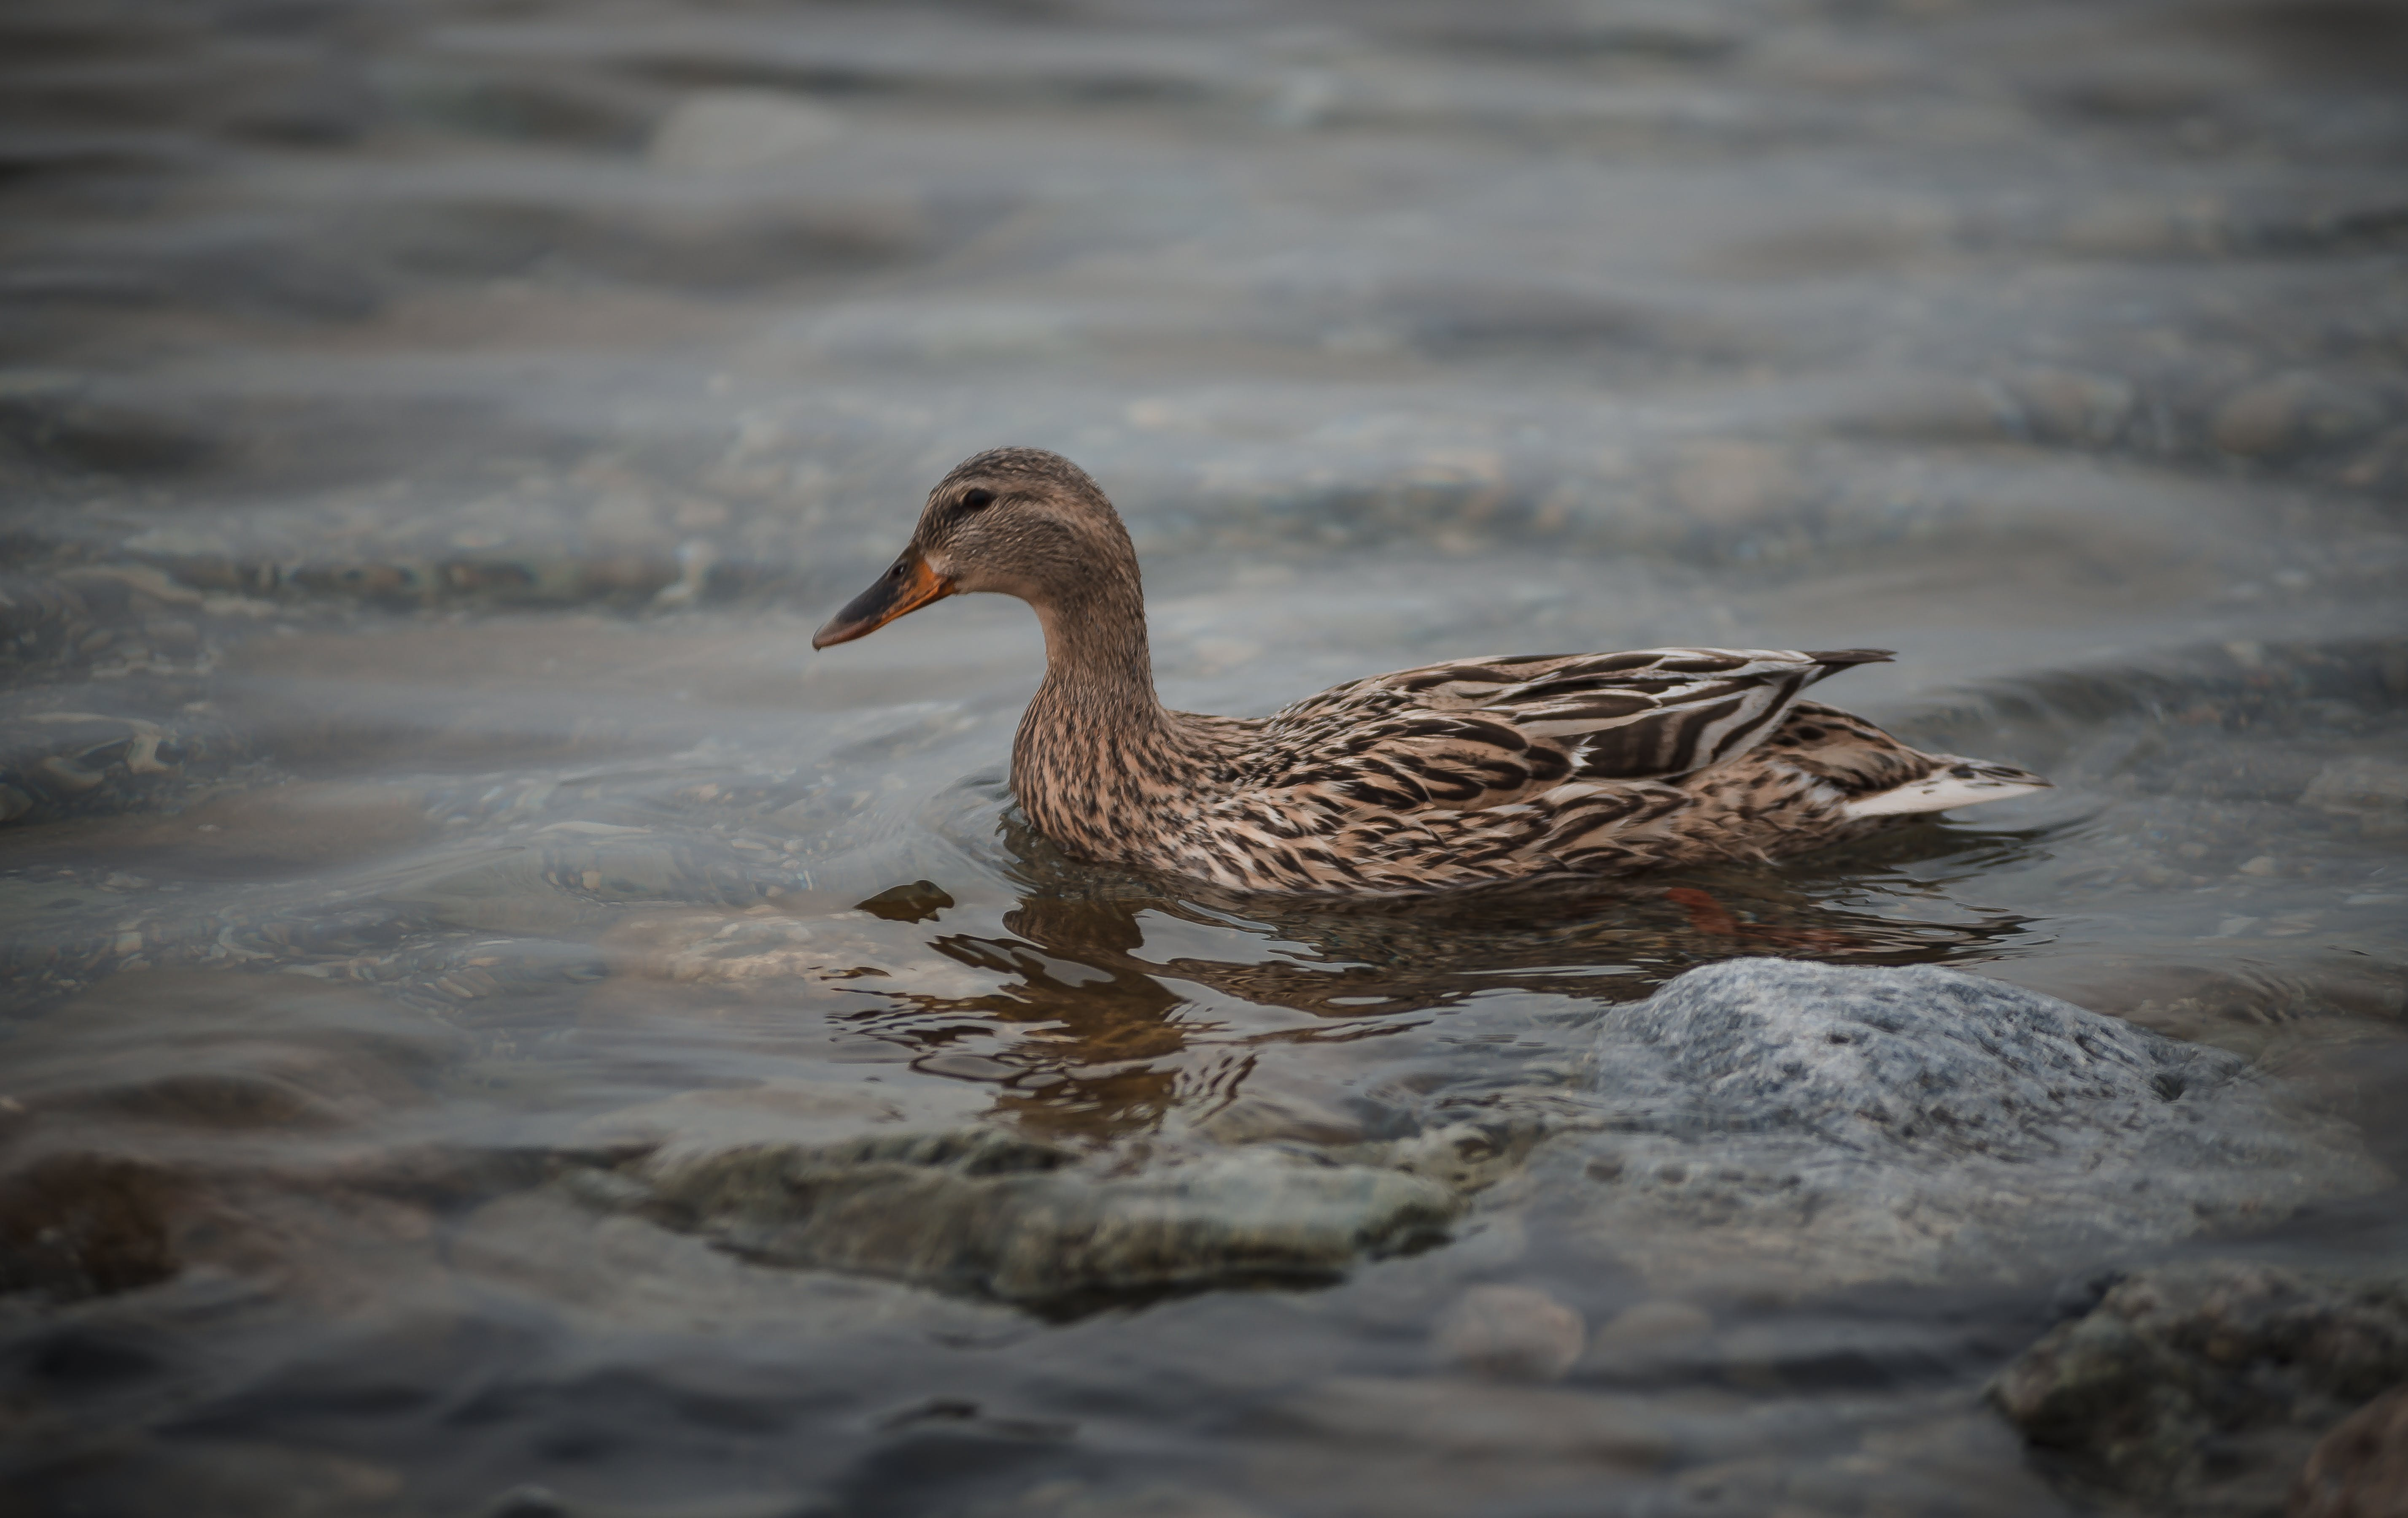

2


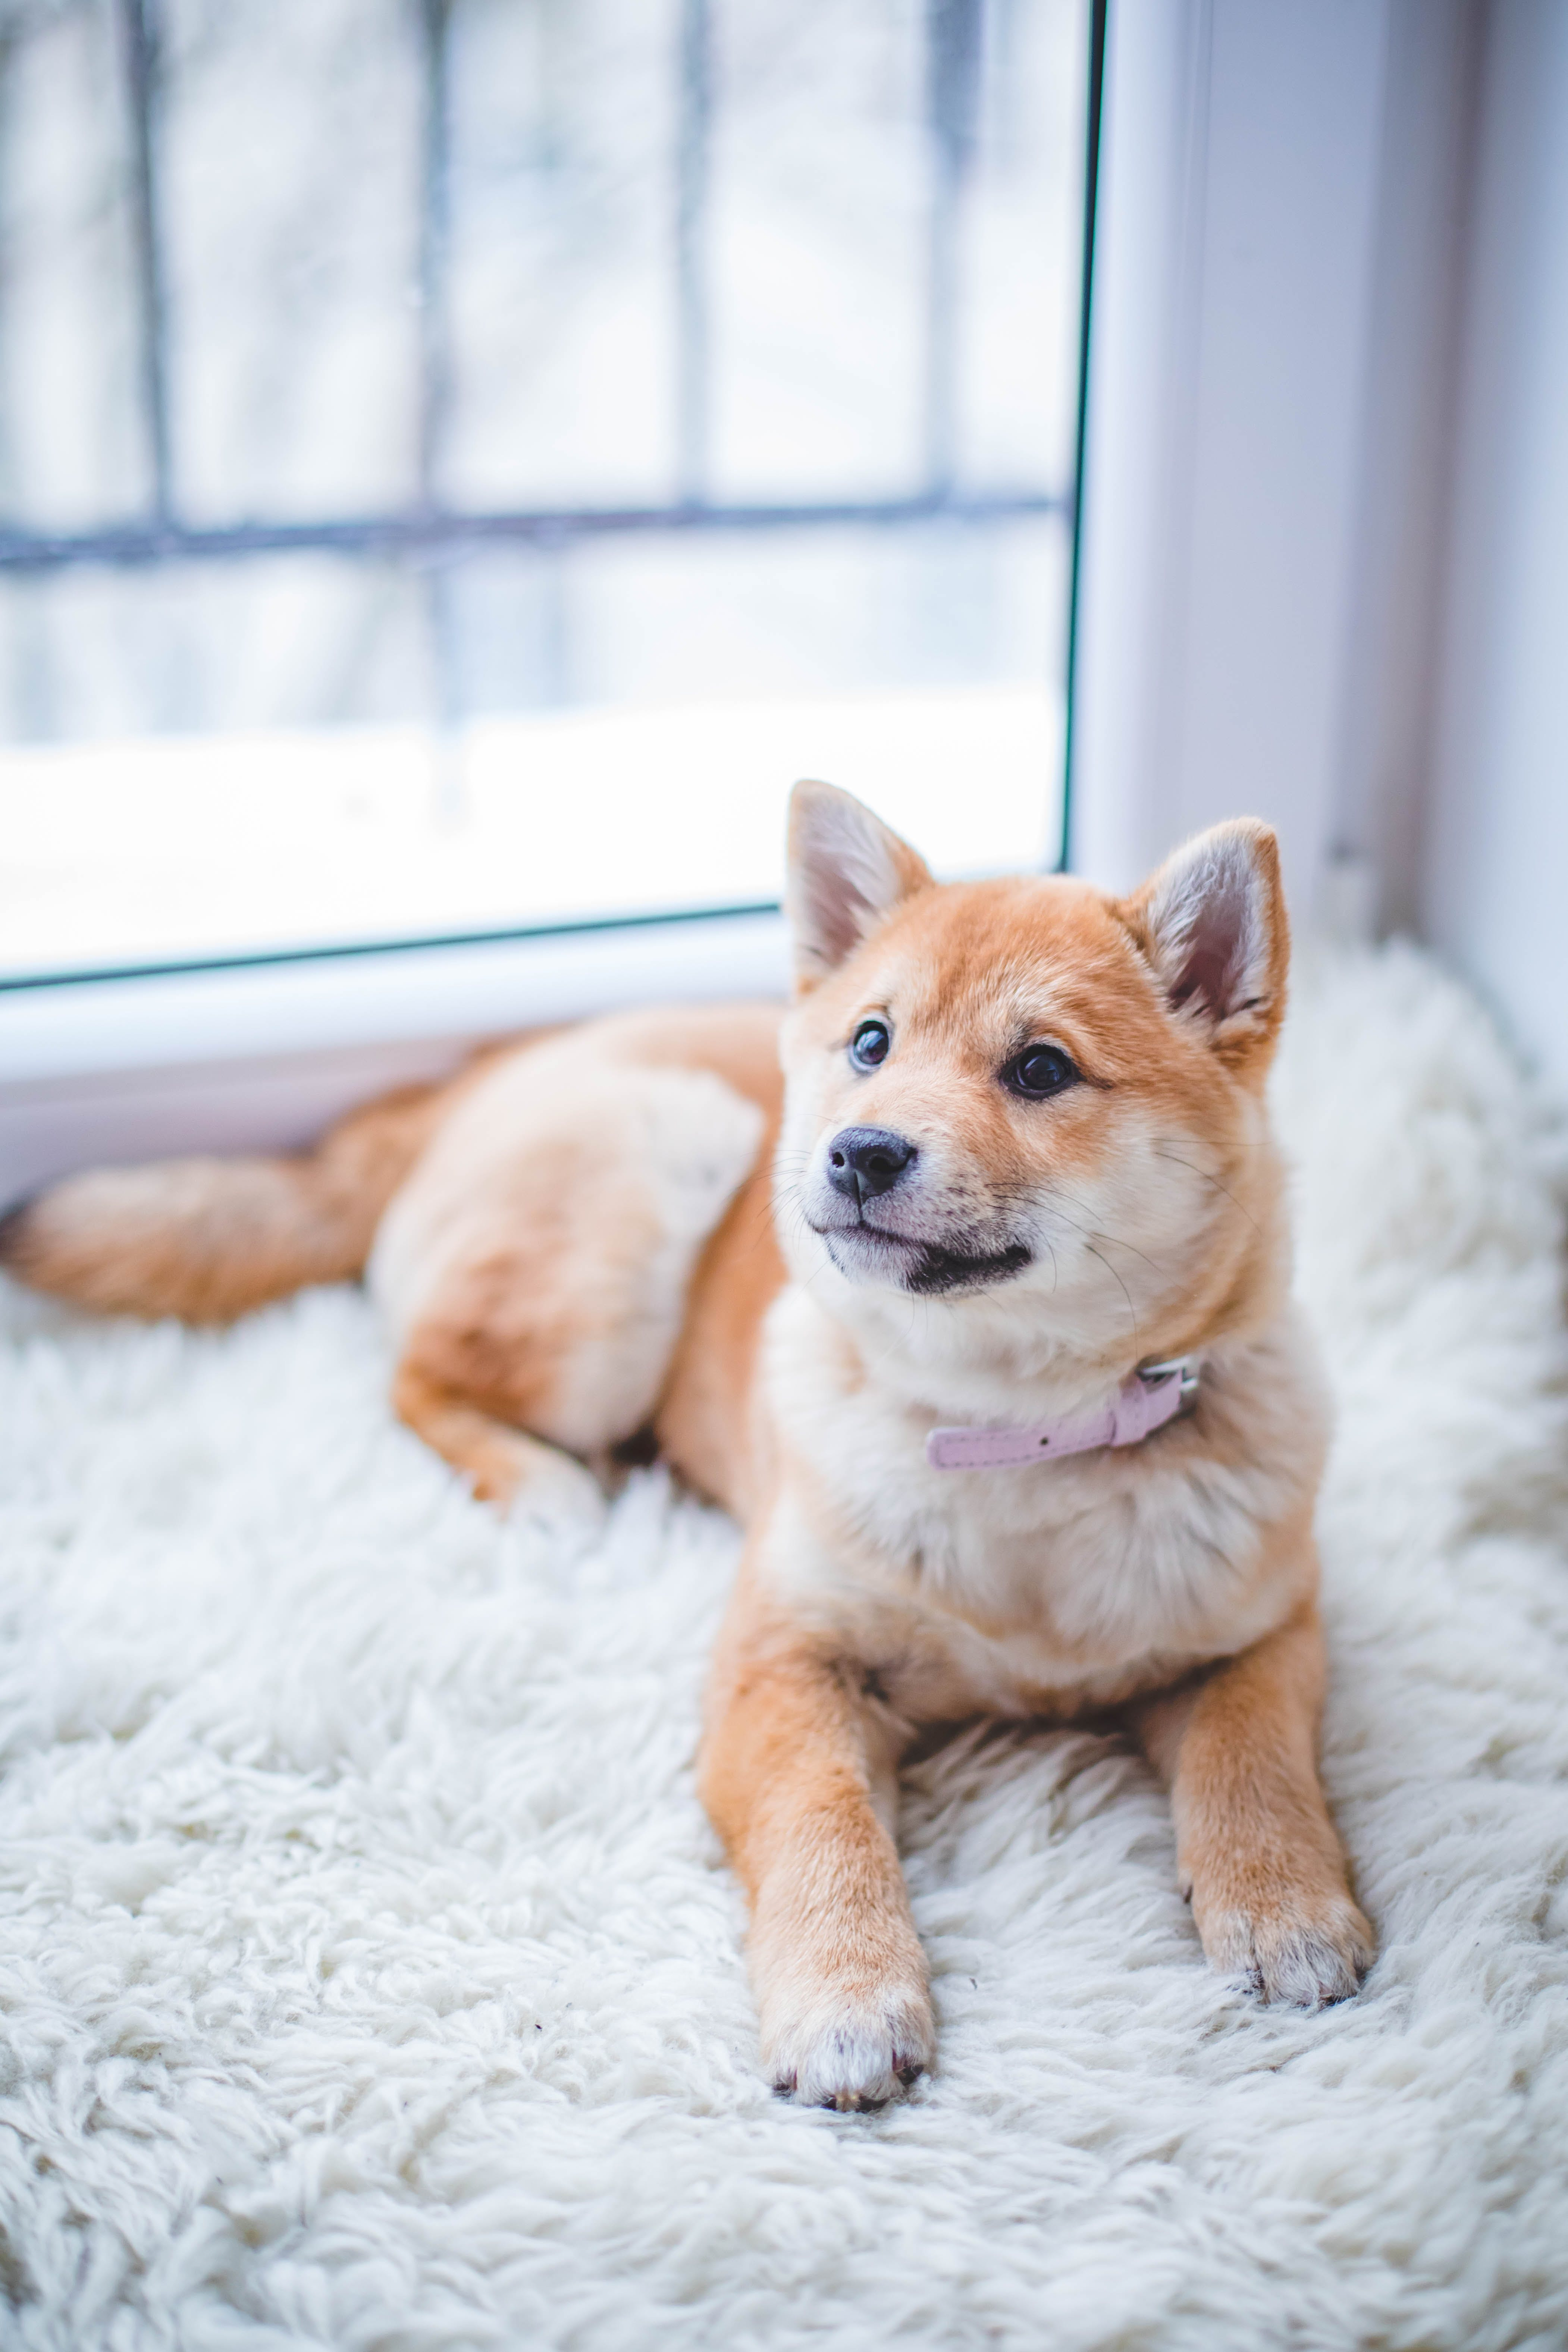

3


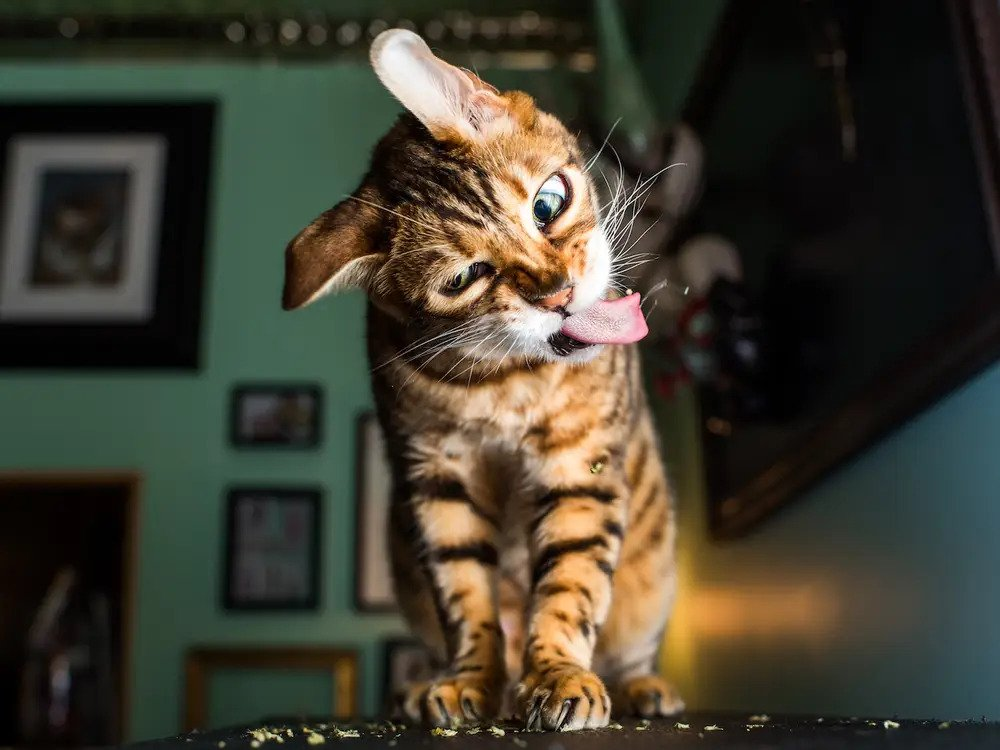

In [88]:
for idx, answer in enumerate(answers): 
    print(idx + 1)
    if answer[0]["file_type"] == "IMAGE":
        img = ImageDisplay(answer[0]["file_path"], width = 200)
        display(img)
    elif answer[0]["file_type"] == "FACT":
        print(answer[0]["text_data"])